Run these first 2 cells to setup the u matrix (and b vector) Cython routines

In [1]:
%load_ext Cython

In [2]:
%%cython

from __future__ import division
import numpy as np
cimport numpy as np
cimport cython
DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

# compile suggestion: gcc -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing -I/somepath/include/python2.7 -o umatrix_routine.so umatrix_routine.c

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
@cython.nonecheck(False)  # turn off negative index wrapping

def umatrix_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(reference_image)[0]
    cdef int nj_image = np.shape(reference_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
    cdef np.ndarray u_matrix = np.zeros([n_kernel + 1, n_kernel + 1], dtype=DTYPE)

    for idx_p in range(n_kernel):
        for idx_q in range(idx_p,n_kernel):
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * reference_image[idx_i + idx_l_prime,idx_j + idx_m_prime]  * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
            u_matrix[idx_q, idx_p] = sum_acc

    for idx_p in [n_kernel]:
        for idx_q in range(n_kernel):
            sum_acc = 0.
            idx_l = kernel_size
            idx_m = kernel_size
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l_prime, idx_j + idx_m_prime] * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
    
    for idx_p in range(n_kernel):
        for idx_q in [n_kernel]:
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime = kernel_size
            idl_m_prime = kernel_size
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half, nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * weights[idx_i, idx_j] 
            u_matrix[idx_p, idx_q] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += weights[idx_i, idx_j] 
    u_matrix[n_kernel, n_kernel] = sum_acc
    
    return u_matrix

def bvector_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] data_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(data_image)[0]
    cdef int nj_image = np.shape(data_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
        
    cdef np.ndarray b_vector = np.zeros([n_kernel + 1], dtype=DTYPE)
    for idx_p in range(n_kernel):
        idx_l, idx_m = pandq[idx_p]
        sum_acc = 0.
        for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
            for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                   sum_acc += data_image[idx_i, idx_j] * reference_image[idx_i + idx_l , idx_j + idx_m ] * weights[idx_i, idx_j]
        b_vector[idx_p] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += data_image[idx_i, idx_j] * weights[idx_i, idx_j]
    b_vector[n_kernel] = sum_acc

    return b_vector

In [3]:
# other useful imports
import os
import astropy
from astropy.io import fits
from scipy.signal import convolve2d
from scipy.optimize import minimize
from scipy.stats import norm
from MakeFakeImage import MakeFake
import time
import matplotlib.pyplot as plt
import PyTorchDIA_Newton_real
import torch
%matplotlib inline

PyTorch version: 1.5.1


In [4]:
## Specify all the functions required ##

def extend_image(image, kernel_size):
    image_extended = np.zeros((np.shape(image)[0] + 2 * kernel_size,
                             np.shape(image)[1] + 2 * kernel_size))
    image_extended[kernel_size:-kernel_size, kernel_size:-kernel_size] = np.array(image, float)
    
    return image_extended

def make_noiseless_target(kernel_sigma, kernel_size, image, add_variable, reference_psf_sigma):

    kernel = np.exp(-0.5 * (np.arange(-np.int((kernel_size/2)), np.int(kernel_size/2)+1)[:, None] ** 2
            + np.arange(-np.int((kernel_size/2)), np.int(kernel_size/2)+1)[None, :] ** 2)/kernel_sigma**2)
    
    kernel /= np.sum(kernel) # normalise kernel
    
    #print('Constructed kernel with shape', kernel.shape)
    #plt.figure()
    #plt.title('Target kernel')
    #plt.imshow(kernel)
    #plt.colorbar()
    
    if add_variable is True:
        nx, ny = image.shape
        xg, yg = np.meshgrid(range(nx), range(ny))
        centre = np.int(image.shape[0]/2)
        positions = np.array([[centre, centre]])
        fluxes = np.array([1e4])
        for pos, f in zip(positions, fluxes):
            ref_psf = np.exp(-0.5 * ((xg - pos[0]) ** 2 + (yg - pos[1]) ** 2)
                    / reference_psf ** 2)
            
            # normalise psf and scale by f
            image += f * ref_psf / (2. * np.pi * reference_psf ** 2)
    
    blurred_image = convolve2d(image, kernel, mode='same')
    
    ks_x, ks_y = kernel.shape[0], kernel.shape[1]
    
    # crop edges affected by convolution
    blurred_image = blurred_image[ks_x:blurred_image.shape[0]-ks_x, ks_y:blurred_image.shape[1]-ks_y]
    
    return blurred_image

def add_noise_to_image(image, read_noise):
    noise_map = np.random.normal(0, 1, size=image.shape)
    sigma_I = np.sqrt(read_noise**2 + image)
    image += noise_map*sigma_I
    return image, sigma_I

def add_less_noise_to_image(image, read_noise):
    # 10 times less variance than add_noise_to_image
    noise_map = np.random.normal(0, 1, size=image.shape)
    sigma_I = 10**(-0.5) * np.sqrt(read_noise**2 + image)
    image += noise_map*sigma_I
    return image, sigma_I

# function to build the kernel, U matrix and b vector
def construct_kernel_and_matrices(kernel_size, R, I, weights):

    pandq = []
    n_kernel = kernel_size * kernel_size
    ncount = 0
    half_kernel_size = int(int(kernel_size) / 2)
    for lidx in range(kernel_size):
        for midx in range(kernel_size):
            pandq.append((lidx - half_kernel_size, midx - half_kernel_size))


    R = R.astype('float64')
    I =  I.astype('float64')
    weights = weights.astype('float64')

    start_time = time.time()
    U = umatrix_construction(R, weights, pandq, n_kernel, kernel_size)
    b = bvector_construction(R, I, weights, pandq, n_kernel, kernel_size)
    print("--- Finished U and b construction in %s seconds ---" % (time.time() - start_time))
    return U, b


# define a function for the least-squares solution
def lstsq_solution(R, I, U, b, kernel_size):
    
    lstsq_result = np.linalg.lstsq(np.array(U), np.array(b), rcond=None)
    a_vector = lstsq_result[0]
    lstsq_fit = np.dot(np.array(U), a_vector)
    resid = np.array(b) - lstsq_fit
    reduced_chisqr = np.sum(resid ** 2) / (float(kernel_size * kernel_size))
    lstsq_cov = np.dot(np.array(U).T, np.array(U)) * reduced_chisqr
    resivar = np.var(resid, ddof=0) * float(len(a_vector))
    
    # use pinv in order to stabilize calculation
    a_var = np.diag(np.linalg.pinv(lstsq_cov) * resivar)

    a_vector_err = np.sqrt(a_var)
    output_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        output_kernel = a_vector[:-1]
    else:
        output_kernel = a_vector
    output_kernel = output_kernel.reshape((kernel_size, kernel_size))

    err_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        err_kernel = a_vector_err[:-1]
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))
    else:
        err_kernel = a_vector_err
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))

    output_kernel_2 = np.flip(np.flip(output_kernel, 0), 1)
    err_kernel_2 = np.flip(np.flip(err_kernel, 0), 1)
    bkg_kernel = a_vector[-1]
    output_kernel_2.shape

    return output_kernel_2, bkg_kernel

# define function to return the model image
def model_image(R, kernel, B0):
    model = convolve2d(R, kernel, mode='same') + B0
    return model

# define function to return the MSE fit quality metric
def calc_MSE(M, I_noiseless, kernel_size):
    
    # crop image edges to exlcude convolution artefacts
    M = M[kernel_size:M.shape[0]-kernel_size, kernel_size:M.shape[1]-kernel_size]
    I_noiseless = I_noiseless[kernel_size:I_noiseless.shape[0]-kernel_size,
                              kernel_size:I_noiseless.shape[1]-kernel_size]
    
    # calculate MSE
    N_data = len(I_noiseless.flatten())
    MSE = 1./(N_data) * np.sum((M - I_noiseless)**2)
    return MSE

# define function to return the MFB and MFV fit quality metrics
def calc_MFB_and_MFV(M, I, noise_map, kernel_size):
    
    # crop image edges to exlcude convolution artefacts
    M = M[kernel_size:M.shape[0]-kernel_size, kernel_size:M.shape[1]-kernel_size]
    I = I[kernel_size:I.shape[0]-kernel_size, kernel_size:I.shape[1]-kernel_size]
    noise_map = noise_map[kernel_size:noise_map.shape[0]-kernel_size, kernel_size:noise_map.shape[1]-kernel_size]
    
    # calculate metrics
    N_data = len(I.flatten())
    #MSE = 1./(N_data) * np.sum((M - I)**2)
    MFB = 1./(N_data) * np.sum((I - M)/noise_map)
    MFV = 1./(N_data - 1) * np.sum((((I - M)/noise_map) - MFB)**2)
    return MFB, MFV

# plot the normalised residuals in D overlain with unit gaussian
def plot_normalised_residuals(epsilon):
    plt.figure(figsize=(5,5))
    plt.hist(epsilon.flatten(), bins='auto', density=True)
    x = np.linspace(-5, 5, 100)
    plt.plot(x, norm.pdf(x, 0, 1))
    plt.xlim(-5, 5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Normalised residuals', fontsize=20)
    plt.ylabel('Probability', fontsize=20)
    plt.show()


    
def plot_image(image, title):
    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.colorbar()
    plt.show()

# define function to return the normalised_psf_object
def normalised_psf_object(psf_sigma, psf_size):
    # first of, let's create the normalised PSF object to fit
    psf = np.zeros((psf_size, psf_size))
    nx, ny = psf_size, psf_size
    xg, yg = np.meshgrid(range(nx), range(ny))
    ## Let's extend this to 2 dimensions ##
    centre = np.int(nx/2)
    pos = [centre, centre]
    f = 1 # i.e. normalised
    kernel = np.exp(-0.5 * ((xg - pos[0]) ** 2 + (yg - pos[1]) ** 2)/ psf_sigma ** 2)
    kernel /= np.sum(kernel) # normalise
    psf += f * kernel #/ (2. * np.pi * psf_sigma ** 2)
    return psf

# cutout around the brightest star
def cutout(image, c_size):
    centre = np.int(image.shape[0]/2)
    radius = np.int((c_size/2))
    cutout = image[centre - radius:centre + radius + 1, centre - radius:centre + radius + 1]
    
    # Generate circular mask
    mask_stamp = np.random.normal(0, 3, size=(c_size, c_size))
    for row in mask_stamp:
        for pixel in row:
            coords = np.where(mask_stamp == pixel)
            y_coord, x_coord = coords[0][0], coords[1][0]
            centre_x, centre_y = np.int(cutout.shape[0]/2), np.int(cutout.shape[0]/2)
            delta_x = x_coord - centre_x
            delta_y = y_coord - centre_y
            distance = np.sqrt(delta_x**2 + delta_y**2)
            if distance < radius-1:
                mask_stamp[coords] = 0
            else:
                mask_stamp[coords] = 1
    
    # mask cutout
    #cutout = np.ma.array(cutout, mask=mask_stamp)
    
    return cutout

def fit_results_and_resids(fit, psf, data):
    F_pred, const_pred = fit.x[0], fit.x[1]
    covmatrix = fit.hess_inv
    var = np.diag(covmatrix)
    print('\nPSF fit results:')
    print('F_pred:', F_pred, np.sqrt(var[0]))
    print('Additive constant:', const_pred, np.sqrt(var[1]))
    message = fit.message
    return F_pred, const_pred, message


def save_numpy_as_fits(numpy_array, filename):
    hdu = fits.PrimaryHDU(numpy_array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)
    

'''
# -loglikelihood to minimise in psf fit
# we're fitting the scaling F and some additive constant
def log_likelihood(params, psf_object, data, sigma):
    F, const = params[0], params[1]
    model = F*psf_object + const
    chi2 = np.sum(((data - model)/sigma)**2)
    loglike = -0.5 * chi2
    return -loglike
'''
'''
# fit the psf object to the provided data
def psf_fit(initial_guess, psf_object, data, sigma):
    print('Starting fit')
    #scalar_objecive = log_likelihood(initial_guess, psf_object, data, sigma)
    fit = minimize(log_likelihood, initial_guess)
    F_pred, const_pred = fit.x[0], fit.x[1]
    covmatrix = fit.hess_inv
    var = np.diag(covmatrix)
    print('\nPSF fit results:')
    print('F_pred:', F_pred, np.sqrt(var[0]))
    print('Additive constant:', const_pred, np.sqrt(var[1]))
    return F_pred, const_pred
'''

"\n# fit the psf object to the provided data\ndef psf_fit(initial_guess, psf_object, data, sigma):\n    print('Starting fit')\n    #scalar_objecive = log_likelihood(initial_guess, psf_object, data, sigma)\n    fit = minimize(log_likelihood, initial_guess)\n    F_pred, const_pred = fit.x[0], fit.x[1]\n    covmatrix = fit.hess_inv\n    var = np.diag(covmatrix)\n    print('\nPSF fit results:')\n    print('F_pred:', F_pred, np.sqrt(var[0]))\n    print('Additive constant:', const_pred, np.sqrt(var[1]))\n    return F_pred, const_pred\n"

In [6]:
# number of simulations, where each simulation
# applies a different randomly generated 
# 'noise map' to the target image
n_simulations = 1
# store photometric scale factor and background term
#Ps = np.array([])
#B0s = np.array([])
# store fit metrics

# store the measured residual flux of brightest star in D
#F_measured_values = np.array([])
#var_min_values = np.array([])

# number of iterations to perform for each simulation
# for the first three iterations, we update the noise model
# used by the pyDANDIA solution. On the last i.e. 4th iteration
# we call the PyTorch code, which iterates 3 times automatically
n_iters = 4

#MSEs = np.array([])
#MFBs = np.array([])
#MFVs = np.array([])
#N_sources = np.array([])
#reference_psf_sigmas = np.array([])
#sky_levels = np.array([])
#kernel_sigmas = np.array([])
#ref_SNRs = np.array([])
#targ_SNRs = np.array([])
for simulation in range(0, n_simulations):
    pyDANDIA, PyTorch = False, False
    print('\n\nSimulation:', simulation)
    # generate noiseless reference 'ref'
    print('Generating reference...')
    size = 142
    #n_sources = np.random.randint(100, 1000, 1)[0] # 100 - 1000
    log_density = np.random.uniform(0, 3, 1)[0]
    #log_density = np.random.uniform(0, 2, 1)[0]
    star_density = 10**log_density # stars per 100x100 pixels
    n_sources = np.int(star_density * (size**2/100**2))
       
    reference_psf_sigma = np.random.uniform(0.5, 2.5, 1)[0] # this is ~ [1 - 6] fwhm
    sky = np.random.uniform(10, 1000, 1)[0]
    ref_clean, F_frac = MakeFake(N=1, size=size, n_sources=n_sources, psf_sigma=reference_psf_sigma, sky=sky)
    print('Reference properties')
    print('Reference size:', size)
    print('Number of sources:', n_sources)
    print('PSF standard deviation:', reference_psf_sigma)
    print('Sky level:', sky)
    print('F_max/F_total:', F_frac)
    
    print('Target kernel properties')
    kernel_sigma = np.random.uniform(0.5, 2.5, 1)[0] # 0.5 - 2.5!!
    #kernel_size = kernel_sigma * 9 # i.e. about 4*kernel_FWHM (FWHM ~ 2.355*kernel_sigma)
    kernel_size = 19
    kernel_size = (np.ceil(kernel_size) // 2 * 2 + 1).astype(int) # round up to nearest odd integer
    print('Kernel standard deviation:', kernel_sigma)
    print('Kernel size:', kernel_size)
    # convolve the noiseless reference with a kernel
    
    imag_clean = make_noiseless_target(kernel_sigma=kernel_sigma, kernel_size=kernel_size,
                                       image=ref_clean, add_variable=False, reference_psf_sigma=reference_psf_sigma)
    
    
    # read noise
    sigma_0 = 5.
    
    # add noise to the reference image
    #ref, sigma_R = add_noise_to_image(image=ref_clean, read_noise=sigma_0)
    ref, sigma_R = add_less_noise_to_image(image=ref_clean, read_noise=sigma_0)
        
    # add noise to the target image i.e.
    imag, sigma_I = add_noise_to_image(image=imag_clean, read_noise=sigma_0) # need noise map for PSF fitting later on
    
    # crop borders of reference so same size as imag
    ref = ref[kernel_size:ref.shape[0]-kernel_size, kernel_size:ref.shape[1]-kernel_size]
    ref_clean = ref_clean[kernel_size:ref_clean.shape[0]-kernel_size, kernel_size:ref_clean.shape[1]-kernel_size]
    sigma_R = sigma_R[kernel_size:sigma_R.shape[0]-kernel_size, kernel_size:sigma_R.shape[1]-kernel_size]

    
    #plot_image(ref,'R')
    #plot_image(imag, 'I')
    
    print(ref.shape, imag.shape, sigma_I.shape)
    
    # calculate SNR of images
    SNR_ref = np.sum(ref_clean - sky) / np.sqrt(np.sum(sigma_R**2))
    SNR_targ = np.sum(imag_clean - sky) / np.sqrt(np.sum(sigma_I**2))
    print('Reference SNR:', SNR_ref)
    print('Target SNR:', SNR_targ)
    
    # exit if SNR_targ > 1000
    if SNR_targ > 1000:
        print('Target SNR regime out of bounds')
        continue
    
    # 'sky' subtract reference... **crucial** for getting past
    # the strong anticorrelation between P and B0
    ref -= np.median(ref)
    #imag -= np.median(imag)
    #print(ref.shape, imag.shape, weights.shape)
    
    # cache the image and kernel parameters
    #N_sources = np.append(N_sources, n_sources)
    #reference_psf_sigmas = np.append(reference_psf_sigmas, reference_psf_sigma)
    #sky_levels = np.append(sky_levels, sky)
    #kernel_sigmas = np.append(kernel_sigmas, kernel_sigma)
    #ref_SNRs, targ_SNRs = np.append(ref_SNRs, SNR_ref), np.append(targ_SNRs, SNR_targ)
  
    ## run below for noiseless target i.e. should recover fit parameters within limit of computer precision
    ##imag, sigma_I = imag_clean, np.ones(imag_clean.shape) ##
    for i in range(0, n_iters):
        
        
        if i == 0:
        # for first pass, estimate weights with inverse variance map
            weights = 1./(imag + sigma_0**2)
            pyDANDIA_mask = np.zeros(weights.shape)
            
        else:
            weights = 1./(M + sigma_0**2)
        
           
        if i < 3:

            weights[np.where(pyDANDIA_mask == 1)] = 1e-99
            print('\nMasked pixels (pyDANDIA):', np.sum(pyDANDIA_mask))

            print('\npyDANDIA solution, iter %d' % i)
            ext_ref = extend_image(ref, kernel_size)
            ext_imag = extend_image(imag, kernel_size)
            ext_weights = extend_image(weights, kernel_size)

            U, b = construct_kernel_and_matrices(kernel_size, ext_ref, ext_imag, ext_weights)
            kernel, B0 = lstsq_solution(ext_ref, ext_imag, U, b, kernel_size)
            if i == 2:
                pyDANDIA = True
        
        elif i == 3:
            print('\nPyTorchDIA solution')
            pyDANDIA = False
            PyTorch = True
            kernel, B0, pl, pl, pl = PyTorchDIA_Newton_real.DIA(ref,
                                       imag,
                                       np.ones(imag.shape), # flatfield
                                       read_noise = 5.,
                                       tot_im = 1,
                                       unweighted=False,
                                       n_samples=1,
                                       full_image=True,
                                       display_stamps=False, 
                                       sky_subtract = False,
                                       iters=3,
                                       ks = kernel_size,
                                       lr_kernel = 1e-2,
                                       lr_B = 10,
                                       SD_steps = 1000,
                                       Newton_tol = 1e-6,
                                       poly_degree=0,
                                       fast=True,
                                       tol = 1e-9,
                                       alpha = 0., 
                                       max_iterations = 5000,
                                       fisher=False,
                                       show_convergence_plots=False,
                                       display_D=False,
                                       k=1e99,
                                       precision=3,
                                       display_masked_stamps=False,
                                       display_M=False,
                                       display_kernel=False,
                                       display_B = False)
        
        M = model_image(ref, kernel, B0)
        if i < 3:
            weights = 1./(M + sigma_0**2)
            norm_resids = np.sqrt(weights)*(imag - M)
            pyDANDIA_mask[np.where(np.abs(norm_resids)>1e99)] = 1
        #plt.imshow(pyDANDIA_mask)
        #plt.show()
        
        #plt.figure(figsize=(5,5))
        #plt.hist(norm_resids.flatten(), bins='auto', density=True)
        #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        #x = np.linspace(-5, 5, 100)
        #plt.plot(x, norm.pdf(x, 0, 1))
        #plt.xlim(-5, 5)
        #plt.xticks(fontsize=20)
        #plt.yticks(fontsize=20)
        #plt.xlabel('Normalised residuals', fontsize=20)
        #plt.ylabel('Probability', fontsize=20)
        #plt.savefig(os.path.join(path, 'NormalisedResids.png'), bbox_inches='tight', overwrite=True)
        #plt.show()
        
                
        if np.any(M < 0.) is True:
            print('Negatives in Model Image! Fitting failed!')
            print('Skipping simulation...')
            break
        
        ## on the final iteration only, compute fit metrics,
        ## and perform PSF fitting photometry
        ## at the position of the brightest star
        #if i == n_iters - 2:
        if pyDANDIA == True or PyTorch == True:
            
            #save_numpy_as_fits(M, 'M_B16.fits')
            #save_numpy_as_fits(ref, 'ref_B16.fits')
            #save_numpy_as_fits(imag, 'imag_B16.fits')
            
            # visually inspect the kernel
            #plot_image(kernel, 'Inferred Kernel')
            # print best fit parameters
            print('\nPhotometric Scale Factor:', np.sum(kernel))
            print('B_0:', B0)

            # store the fit parameters
            #Ps = np.append(Ps, np.sum(kernel))
            #B0s = np.append(B0s, B0)

            # Fit quality metrics
            MSE = calc_MSE(M, imag_clean, kernel_size)
            MFB, MFV = calc_MFB_and_MFV(M, imag, sigma_I, kernel_size)
            #MSEs, MFBs, MFVs = np.append(MSEs, MSE), np.append(MFBs, MFB), np.append(MFVs, MFV)
            print('\nQuality Metrics:')
            print('MSE', MSE)
            print('MFB', MFB)
            print('MFV', MFV)
            print('\n')

            # cutout stamp of bright star from difference image - size == size_psf_object
            D = imag - M
                        
            # check normalised residuals
            #epsilon  = D * np.sqrt(weights)
            #plot_normalised_residuals(epsilon)

            # visually inspect D
            #plot_image(D, 'D')
            
            # PSF fitting photometry of brightest, central star
            target_psf_sigma = np.sqrt(reference_psf_sigma**2 + kernel_sigma**2)
            stamp_size = target_psf_sigma * 9 # i.e. about 4*target_FWHM
            #stamp_size /= 2 # i.e. a 2fwhm x 2fwhm stamp
            stamp_size = (np.ceil(stamp_size) // 2 * 2 + 1).astype(int) # round up to nearest odd integer
            
            psf_object = normalised_psf_object(reference_psf_sigma, stamp_size)
            true_target_psf_object = normalised_psf_object(target_psf_sigma, stamp_size)

            # convolve normalised psf_object with the kernel and re-normalise
            target_psf_object = convolve2d(psf_object, kernel, mode='same')
            target_psf_object = target_psf_object / np.sum(target_psf_object)
            print('Target PSF object sum:', np.sum(target_psf_object))

            ### output fits ##
            hdu = fits.PrimaryHDU(target_psf_object)
            hdul = fits.HDUList([hdu])
            hdul.writeto('target_psf_object.fits', overwrite=True)
            
            # make stamp around position of bright star in D
            stamp = cutout(D, stamp_size)

            # cutout noise in target image to weight the fit
            noise_stamp = cutout(sigma_I, stamp_size)
            
            save_numpy_as_fits(cutout(imag, stamp_size), 'imag_stamp.fits')
            save_numpy_as_fits(stamp, 'D_stamp.fits')
            save_numpy_as_fits(D, 'D.fits')
            save_numpy_as_fits(imag, 'imag.fits')
            save_numpy_as_fits(noise_stamp, 'noise_stamp.fits')
            save_numpy_as_fits(target_psf_object, 'target_psf_object.fits')
            save_numpy_as_fits(true_target_psf_object, 'true_target_psf_object.fits')
            
            
     
            F_diff = torch.nn.Parameter(torch.ones(1), requires_grad=True)
            const = torch.nn.Parameter(torch.ones(1), requires_grad=True)
            print('Starting F_diff and const:', F_diff, const)

            target_psf_object = torch.from_numpy(target_psf_object)
            stamp = torch.from_numpy(stamp)
            noise_stamp = torch.from_numpy(noise_stamp)
            
            class log_likelihood(torch.nn.Module):

                def forward(model, stamp, noise_stamp):
                    loglikelihood = -0.5*(((stamp - model)/noise_stamp)**2).sum()
                    return -loglikelihood
                
            #optimizer = torch.optim.LBFGS([F_diff, const])
            optimizer = torch.optim.Adam([F_diff, const], lr=10)

            tol = 1e-10
            losses = []
            F_diffs = []
            for i in range(0, 1000000):
                #print(i)
                #optimizer.step(closure)
                optimizer.zero_grad()
                model = F_diff*target_psf_object + const
                F_diffs.append(F_diff.item())
                loss = log_likelihood.forward(model, stamp, noise_stamp)
                losses.append(loss.item())
                loss.backward()
                optimizer.step()
                
                if i>1 and abs((losses[-1] - losses[-2])/losses[-2]) < tol:
                    print('Converged')
                    break
                

            print('Final F and const:', F_diff, const)
            
            #plt.plot(losses)
            #plt.plot(F_diffs)
            #plt.show()
             
            ## convert tensors back to numpy arrays
            F_diff = F_diff.detach().numpy()
            const = const.detach().numpy()
            target_psf_object = target_psf_object.detach().numpy()
            stamp = stamp.detach().numpy()
            noise_stamp = noise_stamp.detach().numpy()
            
            
            #### Optimal Extraction - Naylor 1998 ####
            #W_ij = (target_psf_object/noise_stamp**2) * (np.sum((target_psf_object**2)/(noise_stamp**2)))**(-1)
            #stamp_sky = np.median(stamp)
            #F_optimal = np.sum(W_ij * (stamp))
            #print('F_optimal', F_optimal)
            
            

            ## Difference flux of brightest star
            F_measured = F_diff / np.sum(kernel)
            #F_measured_values = np.append(F_measured_values, F_measured)

            # Compute the theoretical minimum variance for F_measured
            P_true = 1.
            var_min = (1./P_true**2) * (np.sum((true_target_psf_object**2)/(noise_stamp**2)))**(-1)
            #var_min_values = np.append(var_min_values, var_min)
            print('F_measured/sigma_min:', F_measured/np.sqrt(var_min))
            #np_F_measured = w[0]/np.sum(kernel)
            #print('Numpy F_measured/sigma_min:', np_F_measured/np.sqrt(var_min))
            
            
            out = np.vstack((np.sum(kernel), B0, MSE, MFB, MFV, F_measured, var_min,
                            star_density, reference_psf_sigma, sky, kernel_sigma,
                            SNR_ref, SNR_targ, F_frac))
            
            #path = '/media/james/Seagate_Expansion_Drive#2'
            path = os.getcwd()
            
            #if pyDANDIA == True:
            #    filename = os.path.join(path, 'pyDANDIA_S10_PSFfit_bright_star.txt')
            #    with open(filename, 'a') as f:
            #        np.savetxt(f, out.T)
            #elif PyTorch == True:
            #    filename = os.path.join(path, 'PyTorch_S10_PSFfit_bright_star.txt')
            #    with open(filename, 'a') as f:
            #        np.savetxt(f, out.T)            
            



Simulation: 0
Generating reference...
Frac for 142x142 image: 0.10948682101042158
Reference properties
Reference size: 142
Number of sources: 248
PSF standard deviation: 2.2790217776878183
Sky level: 630.3767096133162
F_max/F_total: 0.16915255840145313
Target kernel properties
Kernel standard deviation: 1.6422435361359982
Kernel size: 19
(104, 104) (104, 104) (104, 104)
Reference SNR: 685.4226959650715
Target SNR: 180.43266259506194

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0
--- Finished U and b construction in 1.3593549728393555 seconds ---

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 1
--- Finished U and b construction in 1.4003911018371582 seconds ---

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 2
--- Finished U and b construction in 1.4881184101104736 seconds ---

Photometric Scale Factor: 1.012610684012238
B_0: 647.2210597678562

Quality Metrics:
MSE 703.7278996590248
MFB -0.04197798661551832
MFV 0.9735828240704572


Target PSF object sum: 1.

In [ ]:
### Save output into a single file
print(Ps.shape, B0s.shape, MSEs.shape, MFBs.shape, MFVs.shape, F_measured_values.shape, var_min_values.shape)
print(N_sources.shape, reference_psf_sigmas.shape, sky_levels.shape, kernel_sigmas.shape)
print(ref_SNRs.shape, targ_SNRs.shape)
out_file = np.vstack((Ps, B0s, MSEs, MFBs, MFVs, F_measured_values, var_min_values,
                     N_sources, reference_psf_sigmas, sky_levels, kernel_sigmas,
                     ref_SNRs, targ_SNRs))
print(out_file.T.shape)
np.savetxt('simulation_results_pyDANDIA_S1.txt', out_file.T)

In [25]:
print(Ps.shape, B0s.shape, MSEs.shape, MFBs.shape, MFVs.shape, F_measured_values.shape, var_min_values.shape)
# Compute the mean photometric bias and mean photometric variance of F_measured
#print(F_measured_values, var_min_values)
N_set = len(F_measured_values)
MPB = (1./N_set) * np.sum(F_measured_values/np.sqrt(var_min_values))
MPV = (1./(N_set - 1)) * np.sum((((F_measured_values/np.sqrt(var_min_values)) - MPB))**2)
print('MPB', MPB)
print('MPV', MPV)

(1000,) (1000,) (1000,) (1000,) (1000,) (1000,) (1000,)
MPB -0.4258806317541751
MPV 1.772317911732414


In [28]:
# Display the fit metrics (and fit parameters)

def hist_metric(title, metrics):
    print(title)
    percentiles = np.percentile(metrics, [34, 50, 66])
    upper_error = percentiles[2] - percentiles[1]
    lower_error = percentiles[1] - percentiles[0]
    print('Median:%f (+%.9f, -%.9f)'% (percentiles[1], upper_error, lower_error))
    #plt.title(title)
    #plt.hist(metrics)
    #plt.xlim(-5,5)
    #plt.show()
    
#hist_metric('MSE', MSEs)
hist_metric('MFB', MFBs)
hist_metric('MFV', MFVs)
hist_metric('$P$', Ps)
hist_metric('$B_0$', B0s)



MFB
Median:0.000407 (+0.004087744, -0.004062360)
MFV
Median:1.355547 (+4.749058570, -0.317919256)
$P$
Median:0.999999 (+0.000001208, -0.000002892)
$B_0$
Median:0.000000 (+0.000000007, -0.000000002)


(1000,)


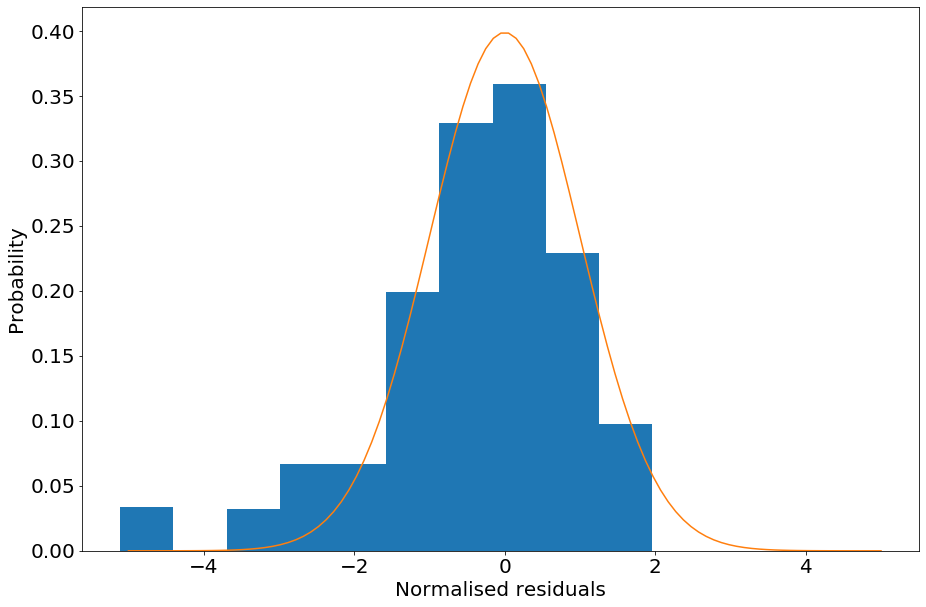

In [38]:
# plot normalised residuals F_measured/sigma_min
norm_resids = F_measured_values/np.sqrt(var_min_values)
print(norm_resids.shape)

plt.figure(figsize=(15,10))
#plt.hist(norm_resids, bins='auto', density=True)
plt.hist(norm_resids, bins=10, density=True)

#x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x = np.linspace(-5, 5, 100)
plt.plot(x, norm.pdf(x, 0, 1))
#plt.xlim(-5, 5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Normalised residuals', fontsize=20)
plt.ylabel('Probability', fontsize=20)
#plt.savefig(os.path.join(path, 'NormalisedResids.png'), bbox_inches='tight', overwrite=True)
plt.show()